# Who survives in the titanic?

> Aim of this notebook is to practice coding in python and to construct my first machine learning workflow.

To do this I will be using the Titanic kaggle problem: https://www.kaggle.com/c/titanic/overview

**Problem statement:** Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

From a top level, this will follow the workflow: 

    1. Data exploration
    2. Feature engineering
    3. Training ML model 
    4. Predict using ML model 
    5. Evaluate predictions
    
On an aside, the following references were used throughout the construction of this notebook:
- https://www.kaggle.com/alexisbcook/titanic-tutorial
- https://www.kaggle.com/daniel68/titanic-a-simple-and-hopefully-clear-approach
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## Baseline

Before starting any data modelling exercise, it's valuable to determine a baseline. We are told that 1502 (67.5%) of the 2224 passengers and crew did not survive. A simple model that classifies all passengers as "Not Survived" will have a corresponding precision of:

Accuracy = (TP + TN) / (TP + TN + FN + FP) = 2224 / 2946 = 75.5%

Precision = TP/(TP+FP) = 1502 / 2224 = 67.5%

where:

    True Positives (TP) = 1502
    True Negatives (TN) = 722
    False Positives (FP) = 2224 - 1502 = 722
    False Negatives (FN) = 0 as we never predict a negative outcome i.e. Survived.

So these are the scores we need to beat.

### Loading libraries and data

In [67]:
import pandas as pd
import numpy as np
import os
import pandas_profiling

from scipy import stats

# Regular expressions
import re

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from jupyterthemes import jtplot # import jtplot submodule from jupyterthemes
jtplot.style()

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import maxabs_scale

# ML model training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics 

In [2]:
# What files are available?
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/gender_submission.csv
C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/test.csv
C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/train.csv


In [81]:
# load in the data and overview of the data structure
train = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/train.csv")
test = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/test.csv")

## Data exploration

In [4]:
print(train.shape) # what are the dimensions/number of training examples?
train.head() # what features do we have?

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# combine train and test together to use all the most data possible for feature exploration/engineering
data = pd.concat([train, test], sort = True).reset_index(drop = True)

### Summarising data
- `Pandas.DataFrame.profile_report()` is a very useful way of summarising data once loaded into a DataFrame (N.B. this requires importing `panda_profiling`)

In [70]:
data.profile_report()

### Manually exploring the data
- We can also manually explore the data, as performed below

#### What column types are there?

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


#### Which columns have missing values?

In [17]:
for col in data.columns:
    
    print("{} has {} missing values".format(col, str(data[col].isna().sum())))

Age has 263 missing values
Cabin has 1014 missing values
Embarked has 2 missing values
Fare has 1 missing values
Name has 0 missing values
Parch has 0 missing values
PassengerId has 0 missing values
Pclass has 0 missing values
Sex has 0 missing values
SibSp has 0 missing values
Survived has 418 missing values
Ticket has 0 missing values


#### Correlation between features

- Sex variable currently coded as string characters, but can be coded as integers to allow correlation with other integer/numeric values

In [62]:
# Convert sex to integer
data["Sex_numeric"] = LabelEncoder().fit_transform(data["Sex"])

# Check conversion
data.loc[:,['Sex','Sex_numeric']].head()

,Sex,Sex_numeric
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


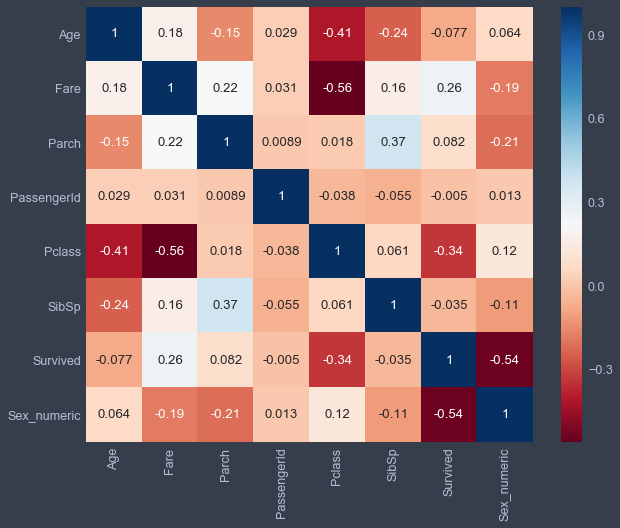

In [53]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr("pearson"), 
            cmap = "RdBu", 
            annot = True)

- Fare, PClass and Sex are the variables that appear to be most correlated with survival 


## Training ML model

### Random forest
- Initial attempt is using code copied from https://www.kaggle.com/alexisbcook/titanic-tutorial
- Random forest model is employed.


#### What is the random forest classifier?
- This model consists of a large number of individual deision trees. Together they operate as an ensemble.
- Each individual tree outputs a class prediction. Thereafter votes for each class are counted and the class with the most votes becomes the entire model's prediction.
- The fundamental concept behind random forest = **wisdom of crowds**. That is, uncorrelated models can produce ensemble predictions that are more accurate than individual predictions. This is because trees protect each from their individual errors.
- For more info, refer to: 
    - https://towardsdatascience.com/understanding-random-forest-58381e0602d2    
    - https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Prequisites for well-performing random forest
1. Features must have predictive power
2. Individual trees need to be relatively uncorrelated i.e. predictions and errors should have low correlations. This is ensured using two methods:
    1. **Bootstrap aggregation (bagging)**: each individual tree randomly samples from the training data *with replacement*. N.B. Bagging does *not* subset training data into smaller chunks and train each tree on different data -- this is due to the sampling with replacement.
    2. **Feature randomness**: each tree picks from a random subset of features i.e. trees use different features to make decisions.


In [86]:
# Extract outcome variable
y = train["Survived"]

# Extract features to use in random forest ML
features = ["Pclass", "Sex", "SibSp", "Parch"]

# Convert categorical variable into dummy/indicator variables
# Do this for training and test data
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/results/RF_submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### What is the performance of our random forest?

- To determine how well RF is performing, it is worthwhile outputting some metrics
- To do this requires that put aside some of our training data to use as validation data
